In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from retrieveData import DataHandler
import scipy.stats as stats
import warnings
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings("ignore")
from statsmodels.graphics.gofplots import qqplot

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (14, 8)


file_path = '/Users/davidboktor/Documents/Tiingo_API.txt'
handler = DataHandler(file_path)


test = handler.test_connections()


Connection successful: {'message': 'You successfully sent a request'}


In [24]:
def plot_distribution(data, title):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Histogram
    ax1.hist(data, bins=50, density=True, alpha=0.7)
    ax1.set_title(f"{title} - Histogram")
    
    # Q-Q plot
    stats.probplot(data, dist="norm", plot=ax2)
    ax2.set_title(f"{title} - Q-Q Plot")
    
    plt.tight_layout()
    plt.show()


# Function to test normality
def is_normal(sample, test=stats.shapiro, p_level=0.05, **kwargs):
    t_stat, p_value = test(sample, **kwargs)
    print("Test statistic: {}, p-value: {}".format(t_stat, p_value))
    print("Is the distribution Likely Normal? {}".format(p_value > p_level))
    return p_value > p_level



In [25]:
data = handler.get_historical_data('AAPL', start_date='2015-01-01', adj_close_only=False)
data.reset_index(inplace=True)

fig = px.line(data, x='date', y='adjClose', title='Historical Price of AAPL')
fig.show()

data.head()


INFO:retrieveData:Successfully fetched data for AAPL


,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,2015-01-02,109.33,111.44,107.350,111.39,53204626,24.372730,24.843109,23.931333,24.831962,212818504,0.0,1.0
1,2015-01-05,106.25,108.65,105.410,108.29,64285491,23.686112,24.221139,23.498852,24.140885,257141964,0.0,1.0
2,2015-01-06,106.26,107.43,104.630,106.54,65797116,23.688341,23.949167,23.324968,23.750761,263188464,0.0,1.0
3,2015-01-07,107.75,108.20,106.695,107.20,40105934,24.020504,24.120822,23.785315,23.897893,160423736,0.0,1.0
4,2015-01-08,111.89,112.15,108.700,109.23,59364547,24.943426,25.001388,24.232286,24.350438,237458188,0.0,1.0


In [26]:
data['log_returns'] = np.log(data['adjClose'] / data['adjClose'].shift(1))
data.dropna(inplace=True)

fig = px.line(data, x='date', y='log_returns', title='Log Returns of AAPL')
fig.show()

Check Normality

Test statistic: 0.9419072099011092, p-value: 7.062697565331518e-30
Is the distribution Likely Normal? False


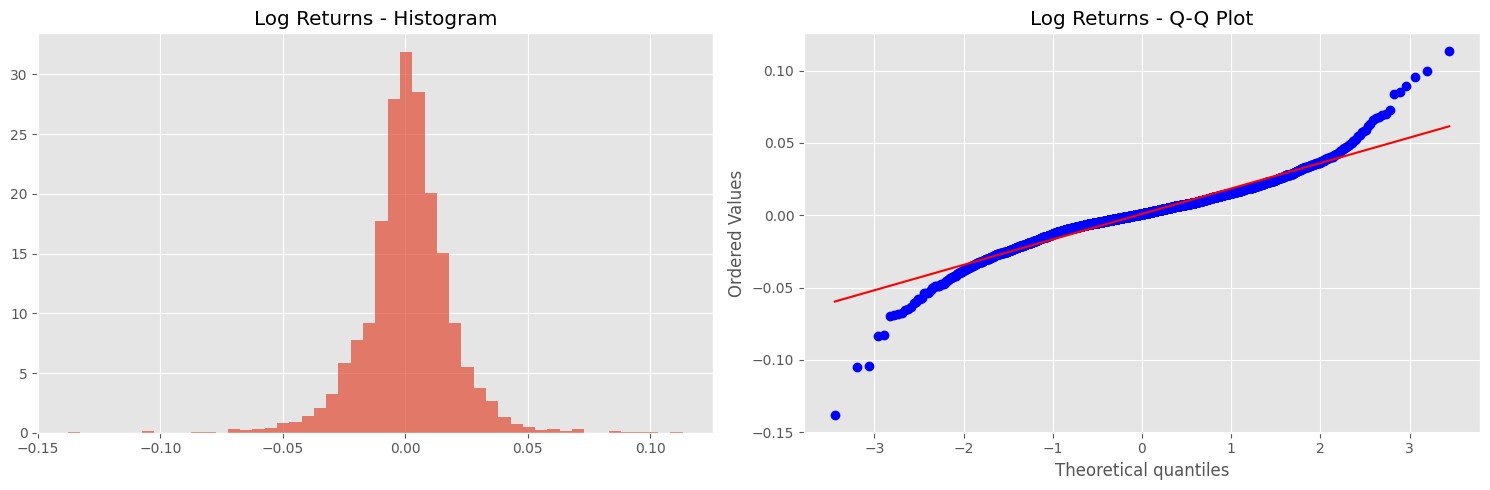

In [27]:
is_normal(data['log_returns'])
plot_distribution(data['log_returns'], 'Log Returns')

Apply Rank based inverse normal transformation to normalized log returns

Test statistic: 0.9999779296307906, p-value: 1.0
Is the distribution Likely Normal? True


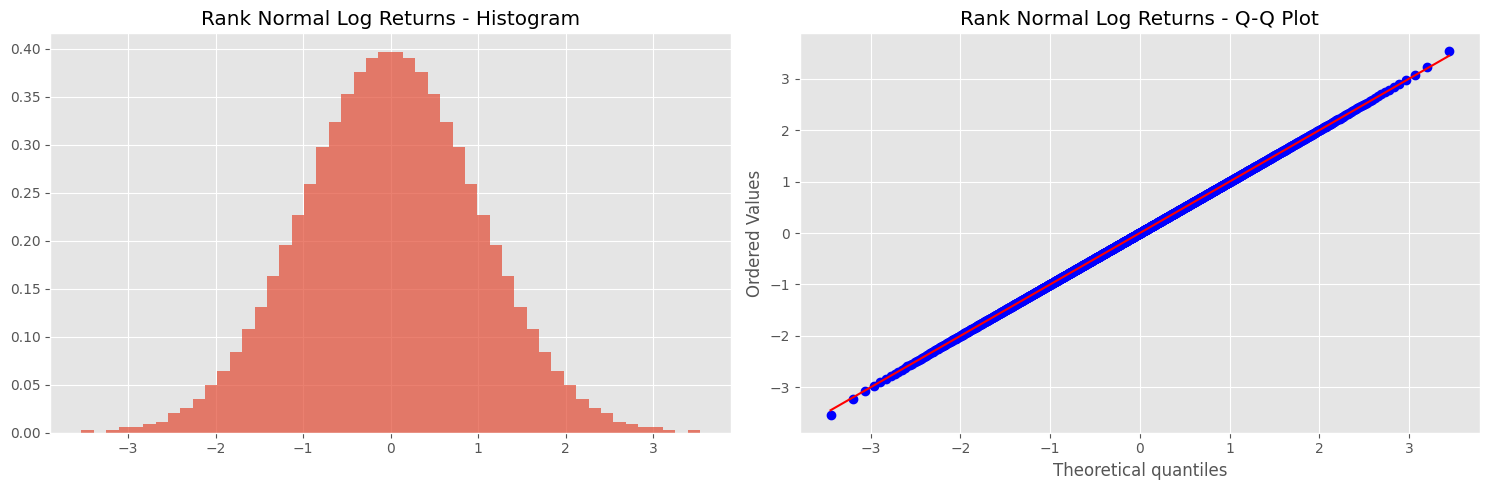

In [28]:
def rank_based_inverse_normal(x):
    return stats.norm.ppf((stats.rankdata(x) - 0.5) / len(x))

data['rank_normal_log_returns'] = rank_based_inverse_normal(data['log_returns'])


is_normal(data['rank_normal_log_returns'])
plot_distribution(data['rank_normal_log_returns'], 'Rank Normal Log Returns')

In [29]:
data.head()

,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor,log_returns,rank_normal_log_returns
1,2015-01-05,106.25,108.65,105.410,108.29,64285491,23.686112,24.221139,23.498852,24.140885,257141964,0.0,1.0,-0.028576,-1.673056
2,2015-01-06,106.26,107.43,104.630,106.54,65797116,23.688341,23.949167,23.324968,23.750761,263188464,0.0,1.0,0.000094,-0.068708
3,2015-01-07,107.75,108.20,106.695,107.20,40105934,24.020504,24.120822,23.785315,23.897893,160423736,0.0,1.0,0.013925,0.903718
4,2015-01-08,111.89,112.15,108.700,109.23,59364547,24.943426,25.001388,24.232286,24.350438,237458188,0.0,1.0,0.037703,2.021331
5,2015-01-09,112.01,113.25,110.210,112.67,53315099,24.970178,25.246609,24.568907,25.117310,213260396,0.0,1.0,0.001072,0.006711


In [65]:
model_data = data[['date','rank_normal_log_returns']]

for i in range(1, 30):
    model_data[f'lag_{i}'] = model_data['rank_normal_log_returns'].shift(i)

model_data.set_index('date', inplace=True)
model_data.dropna(inplace=True)
model_data.head()



,rank_normal_log_returns,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,lag_25,lag_26,lag_27,lag_28,lag_29
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-02-17,0.352498,0.291599,0.821345,1.421155,1.219071,0.416986,-0.749660,0.456739,0.500736,-0.063534,0.814134,-1.071883,1.753657,2.426652,-1.927207,0.005678,0.312129,1.545097,0.497228,1.534958,-0.706594,-1.648458,-0.394566,0.601715,-1.499072,0.006711,2.021331,0.903718,-0.068708,-1.673056
2015-02-18,0.443031,0.352498,0.291599,0.821345,1.421155,1.219071,0.416986,-0.749660,0.456739,0.500736,-0.063534,0.814134,-1.071883,1.753657,2.426652,-1.927207,0.005678,0.312129,1.545097,0.497228,1.534958,-0.706594,-1.648458,-0.394566,0.601715,-1.499072,0.006711,2.021331,0.903718,-0.068708
2015-02-19,-0.250896,0.443031,0.352498,0.291599,0.821345,1.421155,1.219071,0.416986,-0.749660,0.456739,0.500736,-0.063534,0.814134,-1.071883,1.753657,2.426652,-1.927207,0.005678,0.312129,1.545097,0.497228,1.534958,-0.706594,-1.648458,-0.394566,0.601715,-1.499072,0.006711,2.021331,0.903718
2015-02-20,0.543330,-0.250896,0.443031,0.352498,0.291599,0.821345,1.421155,1.219071,0.416986,-0.749660,0.456739,0.500736,-0.063534,0.814134,-1.071883,1.753657,2.426652,-1.927207,0.005678,0.312129,1.545097,0.497228,1.534958,-0.706594,-1.648458,-0.394566,0.601715,-1.499072,0.006711,2.021331
2015-02-23,1.594649,0.543330,-0.250896,0.443031,0.352498,0.291599,0.821345,1.421155,1.219071,0.416986,-0.749660,0.456739,0.500736,-0.063534,0.814134,-1.071883,1.753657,2.426652,-1.927207,0.005678,0.312129,1.545097,0.497228,1.534958,-0.706594,-1.648458,-0.394566,0.601715,-1.499072,0.006711


In [69]:
cutoff_date = '2022-01-01'

train_data = model_data[model_data.index < cutoff_date]
test_data = model_data[model_data.index >= cutoff_date]

X_train = train_data.drop(columns=['rank_normal_log_returns'])
y_train = train_data['rank_normal_log_returns']
X_test = test_data.drop(columns=['rank_normal_log_returns'])
y_test = test_data['rank_normal_log_returns']

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [70]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

y_pred = lr.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

Mean Squared Error: 1.0387711994640256
R^2 Score: -0.012278224844025187


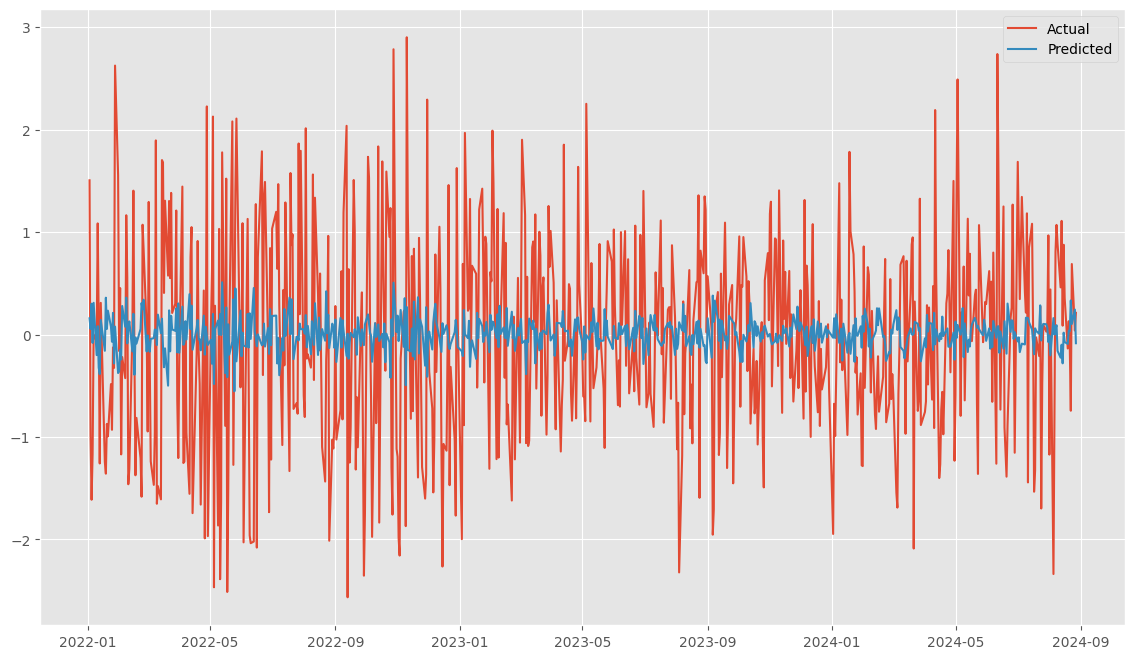

In [71]:
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, y_pred, label='Predicted')
plt.legend()
plt.show()

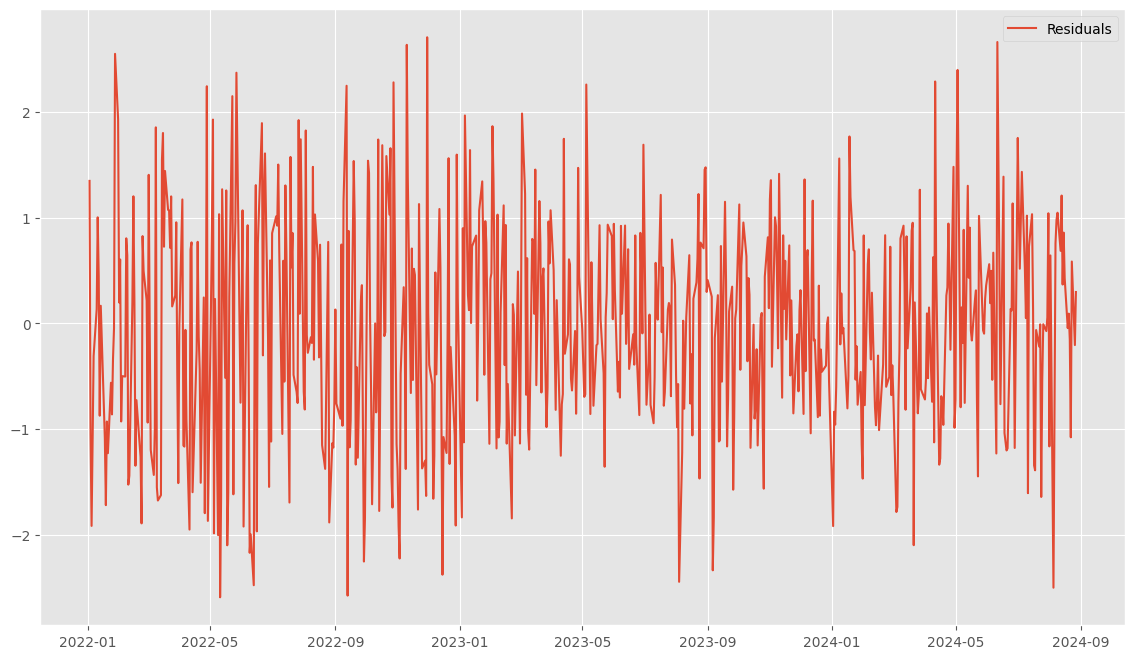

In [72]:
residuals = y_test - y_pred
plt.plot(residuals.index, residuals, label='Residuals')
plt.legend()
plt.show()


Shapiro-Wilk test - Statistic: 0.9960193242934905, p-value: 0.08986924454856504


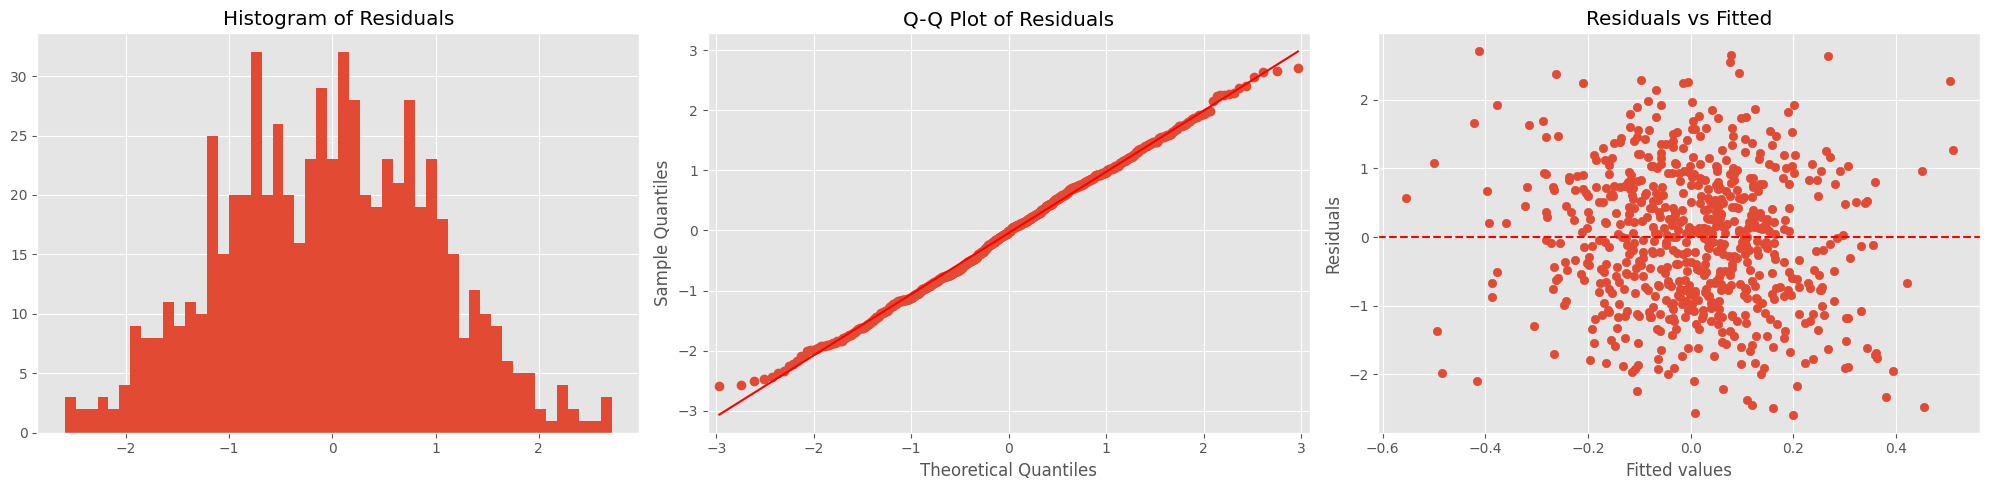

In [73]:
def check_residual_normality(residuals):
    # Shapiro-Wilk test
    stat, p = stats.shapiro(residuals)
    print(f'Shapiro-Wilk test - Statistic: {stat}, p-value: {p}')
    
    # Visual checks
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))
    
    # Histogram
    ax1.hist(residuals, bins=50)
    ax1.set_title('Histogram of Residuals')
    
    # Q-Q plot
    qqplot(residuals, line='s', ax=ax2)
    ax2.set_title('Q-Q Plot of Residuals')
    
    # Residuals vs Fitted
    ax3.scatter(y_pred, residuals)
    ax3.axhline(y=0, color='r', linestyle='--')
    ax3.set_xlabel('Fitted values')
    ax3.set_ylabel('Residuals')
    ax3.set_title('Residuals vs Fitted')
    
    plt.tight_layout()
    plt.show()

check_residual_normality(residuals)